Import all required libraries

In [5]:
from torchvision import datasets, models
from torchvision.datasets import ImageFolder
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import pandas as pd
import torch.nn as nn
import os
import pathlib
import PIL

data_dir = '/content/drive/MyDrive/Colab Notebooks/data'

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


import the input data

In [7]:
data_dir = pathlib.Path(data_dir)

In [8]:
data_dir

PosixPath('/content/drive/MyDrive/Colab Notebooks/data')

In [9]:
image_count = len(list(data_dir.glob('*/*.png')))


In [10]:
image_count

1820

In [7]:
benign = list(data_dir.glob('benign/*'))
aimage=PIL.Image.open(str(benign[5]))




In [8]:
aimage.size#(width, height)

(700, 460)

In [9]:
import tensorflow as tf
batch_size = 32
img_height = 240
img_width = 240
AUTO = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1820 files belonging to 2 classes.
Using 1456 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1820 files belonging to 2 classes.
Using 364 files for validation.


When training vision models, it is common to resize images to a lower dimension ((224 x 224), (299 x 299), etc.) to allow mini-batch learning and also to keep up the compute limitation

check the class names:

In [11]:
class_names = train_ds.class_names
print(class_names)


['benign', 'malignant']


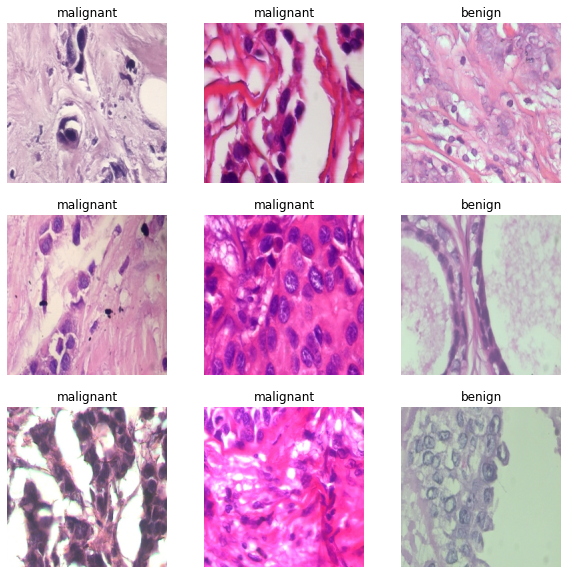

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 240, 240, 3)
(32,)


Normalization:

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [15]:
normalization_layer = layers.Rescaling(1./255)


In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.00011570917 0.9960308


Simple CNN Model keras

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


take "adam" as an optimizer

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Summarization:

In [19]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

Run the model

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
46/46 [==============================] - 19s 207ms/step - loss: 0.8077 - accuracy: 0.6484 - val_loss: 0.5297 - val_accuracy: 0.6676
Epoch 2/10
46/46 [==============================] - 1s 14ms/step - loss: 0.5638 - accuracy: 0.7232 - val_loss: 0.5176 - val_accuracy: 0.6676
Epoch 3/10
46/46 [==============================] - 1s 14ms/step - loss: 0.5154 - accuracy: 0.7727 - val_loss: 0.4234 - val_accuracy: 0.8269
Epoch 4/10
46/46 [==============================] - 1s 14ms/step - loss: 0.4804 - accuracy: 0.7974 - val_loss: 0.5151 - val_accuracy: 0.7005
Epoch 5/10
46/46 [==============================] - 1s 14ms/step - loss: 0.4589 - accuracy: 0.8214 - val_loss: 0.3938 - val_accuracy: 0.8599
Epoch 6/10
46/46 [==============================] - 1s 14ms/step - loss: 0.4182 - accuracy: 0.8386 - val_loss: 0.4317 - val_accuracy: 0.8489
Epoch 7/10
46/46 [==============================] - 1s 14ms/step - loss: 0.3993 - accuracy: 0.8496 - val_loss: 0.4454 - val_accuracy: 0.7802
Epoch 8/10


Check accuracy

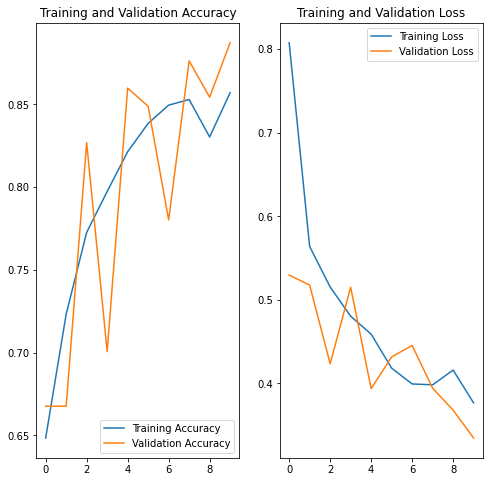

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Can we do Better?
# augement the data for better performance and accuracyy

In [52]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


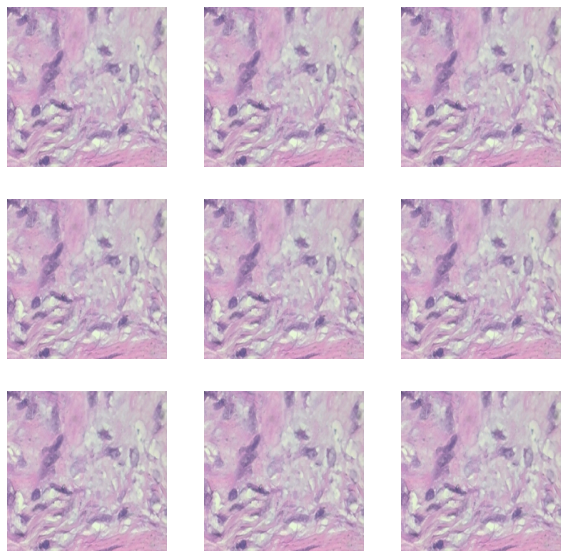

In [53]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

declare the model

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])


In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [26]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [28]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
46/46 [==============================] - 2s 30ms/step - loss: 0.8656 - accuracy: 0.6635 - val_loss: 0.5382 - val_accuracy: 0.6676
Epoch 2/10
46/46 [==============================] - 1s 27ms/step - loss: 0.5397 - accuracy: 0.7445 - val_loss: 0.4933 - val_accuracy: 0.7280
Epoch 3/10
46/46 [==============================] - 1s 27ms/step - loss: 0.5079 - accuracy: 0.7912 - val_loss: 0.4770 - val_accuracy: 0.7912
Epoch 4/10
46/46 [==============================] - 1s 26ms/step - loss: 0.4663 - accuracy: 0.8111 - val_loss: 0.4555 - val_accuracy: 0.7857
Epoch 5/10
46/46 [==============================] - 1s 26ms/step - loss: 0.4650 - accuracy: 0.8201 - val_loss: 0.5006 - val_accuracy: 0.7225
Epoch 6/10
46/46 [==============================] - 1s 26ms/step - loss: 0.4595 - accuracy: 0.8228 - val_loss: 0.4308 - val_accuracy: 0.8516
Epoch 7/10
46/46 [==============================] - 1s 26ms/step - loss: 0.4220 - accuracy: 0.8523 - val_loss: 0.4126 - val_accuracy: 0.8297
Epoch 8/10
46

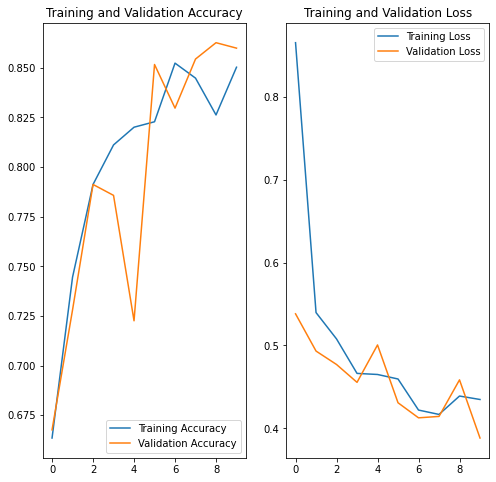

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [30]:
acc

[0.6634615659713745,
 0.7445054650306702,
 0.791208803653717,
 0.8111263513565063,
 0.8200549483299255,
 0.8228021860122681,
 0.8523351550102234,
 0.8447802066802979,
 0.8262362480163574,
 0.8502747416496277]

Resnet50


In [64]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [65]:
from tensorflow.keras.optimizers import Adam

In [66]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/data'

In [67]:
data_dir = pathlib.Path(data_dir)

In [68]:
img_height,img_width=224,224
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1820 files belonging to 2 classes.
Using 1456 files for training.


In [69]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 1820 files belonging to 2 classes.
Using 364 files for validation.


In [70]:
class_names = train_ds.class_names
print(class_names)


['benign', 'malignant']


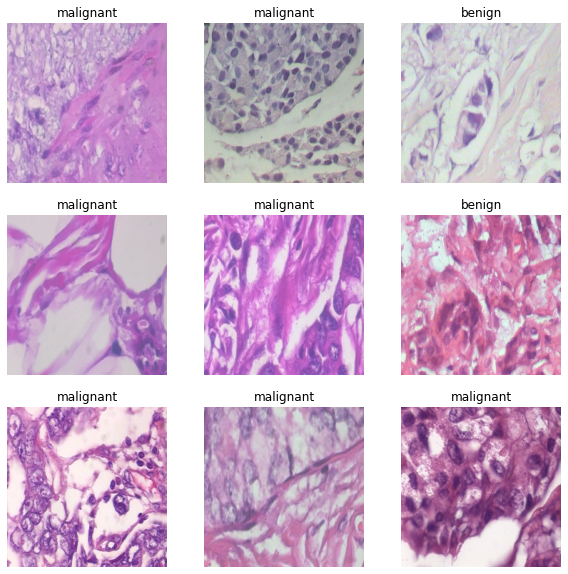

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [72]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [73]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=True,
                   input_shape=(224,224,3),
                   pooling='avg',classes=1000,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [74]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [75]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_3 (Flatten)         (None, 1000)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               512512    
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 26,150,250
Trainable params: 513,538
Non-trainable params: 25,636,712
_________________________________________________________________


In [76]:
resnet_model.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
46/46 [==============================] - 8s 63ms/step - loss: 0.6162 - accuracy: 0.6738 - val_loss: 0.5915 - val_accuracy: 0.6676
Epoch 2/10
46/46 [==============================] - 1s 27ms/step - loss: 0.5524 - accuracy: 0.6875 - val_loss: 0.5290 - val_accuracy: 0.7610
Epoch 3/10
46/46 [==============================] - 1s 27ms/step - loss: 0.4905 - accuracy: 0.7788 - val_loss: 0.4706 - val_accuracy: 0.7857
Epoch 4/10
46/46 [==============================] - 1s 27ms/step - loss: 0.4431 - accuracy: 0.8111 - val_loss: 0.4346 - val_accuracy: 0.8049
Epoch 5/10
46/46 [==============================] - 1s 27ms/step - loss: 0.4106 - accuracy: 0.8249 - val_loss: 0.4248 - val_accuracy: 0.8104
Epoch 6/10
46/46 [==============================] - 1s 27ms/step - loss: 0.3921 - accuracy: 0.8379 - val_loss: 0.4117 - val_accuracy: 0.8104
Epoch 7/10
46/46 [==============================] - 1s 27ms/step - loss: 0.3735 - accuracy: 0.8407 - val_loss: 0.4023 - val_accuracy: 0.8159
Epoch 8/10
46

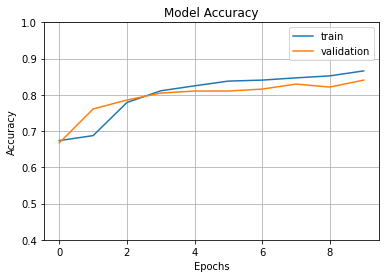

In [77]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

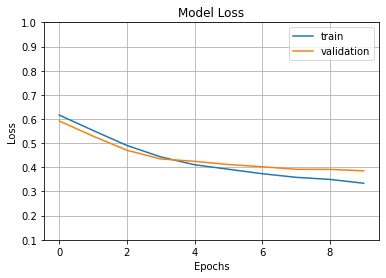

In [78]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [79]:
import cv2
benign = list(data_dir.glob('benign/*'))
image=cv2.imread(str(benign[39]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [80]:
pred=resnet_model.predict(image)

1/1 [==============================] - 1s 890ms/step


In [81]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is benign


In [88]:
import cv2
malignant = list(data_dir.glob('malignant/*'))
image=cv2.imread(str(malignant[95]))
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)

In [89]:
pred=resnet_model.predict(image)

1/1 [==============================] - 0s 25ms/step


In [90]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is malignant


can we do better? with augmentation

In [105]:
resnet_model = Sequential( [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.5),
  ])

pretrained_model= tf.keras.applications.ResNet50(include_top=True,
                   input_shape=(224,224,3),
                   pooling='avg',classes=1000,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [106]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [107]:
resnet_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_6 (Flatten)         (None, 1000)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               512512    
                                                      

In [108]:
resnet_model.compile(optimizer=Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
46/46 [==============================] - 6s 65ms/step - loss: 0.6257 - accuracy: 0.6724 - val_loss: 0.5929 - val_accuracy: 0.6676
Epoch 2/10
46/46 [==============================] - 2s 43ms/step - loss: 0.5543 - accuracy: 0.7054 - val_loss: 0.5632 - val_accuracy: 0.6951
Epoch 3/10
46/46 [==============================] - 2s 43ms/step - loss: 0.5121 - accuracy: 0.7500 - val_loss: 0.5150 - val_accuracy: 0.7637
Epoch 4/10
46/46 [==============================] - 2s 43ms/step - loss: 0.4822 - accuracy: 0.7878 - val_loss: 0.4858 - val_accuracy: 0.7830
Epoch 5/10
46/46 [==============================] - 2s 44ms/step - loss: 0.4548 - accuracy: 0.8029 - val_loss: 0.4765 - val_accuracy: 0.7857
Epoch 6/10
46/46 [==============================] - 2s 43ms/step - loss: 0.4497 - accuracy: 0.8022 - val_loss: 0.4334 - val_accuracy: 0.7857
Epoch 7/10
46/46 [==============================] - 2s 43ms/step - loss: 0.4524 - accuracy: 0.8036 - val_loss: 0.4501 - val_accuracy: 0.7995
Epoch 8/10
46

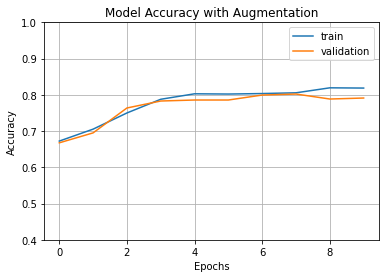

In [109]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy with Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

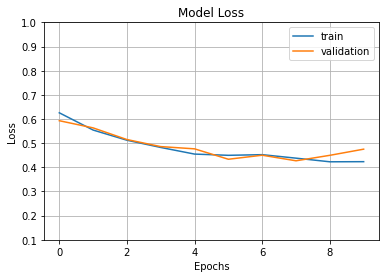

In [110]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

some helpful websites: https://www.tensorflow.org/tutorials/load_data/images